# Import packages

In [1]:
# Install packages
!pip install optuna
!pip install optuna_integration
!pip install bayesian-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 952.5 kB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/hotel_reservation

Mounted at /content/drive
/content/drive/MyDrive/hotel_reservation


In [3]:
# Basic packages
import re
import pandas as pd
import numpy as np

# Data visualization
import seaborn as sns
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "colab"
import matplotlib.pyplot as plt

# Datetime
from datetime import datetime, timedelta

# Data splitting
from sklearn.model_selection import train_test_split

# Bayesian Optimization
from bayes_opt import BayesianOptimization

# Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

# LightGBM ensemble
import lgbt

# Model evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
# Define a function to remove special characters
def clean_column_names(df):
    df.columns = [re.sub(r'[^A-Za-z0-9_]+', '_', col) for col in df.columns]
    return df

def draw_predictions(data: pd.DataFrame) -> None:
    series = data.set_index('ds').unstack().reset_index(drop=False)
    series.columns = ['type', 'ds', 'value']

    plt.figure(figsize=(20, 5))
    sns.lineplot(data=series, x='ds', y='value', hue='type')
    plt.xticks(rotation=90)
    plt.show()

# Import dataset

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/martamalecka/hotel-bookings-analysis/main/hotel_bookings.csv')\
     .rename(columns={'arrival_date_year':'year','arrival_date_month':'month',
                     'arrival_date_day_of_month':'day'})

In [6]:
df.head()

,hotel,is_canceled,lead_time,year,month,arrival_date_week_number,day,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [7]:
def monthToNum(shortMonth):
    return {
            'January': 1,
            'February': 2,
            'March': 3,
            'April': 4,
            'May': 5,
            'June': 6,
            'July': 7,
            'August': 8,
            'September': 9,
            'October': 10,
            'November': 11,
            'December': 12
    }[shortMonth]

df['month'] = df['month'].apply(monthToNum)

In [8]:
df['date']= pd.to_datetime(df[['year', 'month', 'day']])

In [9]:
df = df.drop_duplicates(keep='first')

In [10]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'year', 'month',
       'arrival_date_week_number', 'day', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'date'],
      dtype='object')

In [11]:
df = df[df['adr']<5000]
# Calculating total guests for each record
df['total_guests'] = df['adults'] + df['children'] # + df['num_babies'
# Some data points include zero Total Guests, therefore I dropped them
df = df[df['total_guests'] != 0]

<ipython-input-11-b094591e76e7>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [12]:
# Filter data for City Hotel
df = df[(df['hotel']=='City Hotel')]
ts_df = df.groupby(['date'])['hotel'].count().reset_index().rename(columns={'hotel':'y','date':'ds'})

In [13]:
ts_df['year'] = ts_df.ds.dt.year
ts_df['month'] = ts_df.ds.dt.month
ts_df['day'] = ts_df.ds.dt.day

In [14]:
fig = px.line(ts_df, x="ds", y="y", title='Hotel reservations')
fig.show()

# Split data into training and test data

In [15]:
train_df = ts_df.loc[(ts_df['ds']>='2015-07-01') & (ts_df['ds']<'2017-08-01')]
test_df = ts_df.loc[(ts_df['ds']>='2017-08-01') & (ts_df['ds']<'2017-09-01')]

# Prophet optimization

## Bayesian optimization
Bayesian optimization is faster than grid search and random search

In [16]:
# Function for Bayesian optimization
def prophet_cv(start_date, changepoint_prior_scale, seasonality_prior_scale, seasonality_mode):
    train_df = ts_df.loc[(ts_df['ds'] >= start_date) & (ts_df['ds'] < '2017-08-01')]

    model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        seasonality_mode='multiplicative' if seasonality_mode > 0.5 else 'additive'
    )

    model.add_country_holidays(country_name='PT')

    model.fit(train_df)

    df_cv = cross_validation(model, initial='460 days', period='60 days', horizon='30 days')
    # df_cv = cross_validation(model, initial='500 days', period='180 days', horizon='30 days')
    df_p = performance_metrics(df_cv)

    # Return a negative RMSE because of minimizing it
    return -df_p['rmse'].values[0]

# Bayesian optimization settings
pbounds = {
    'start_date': (ts_df['ds'].min().toordinal(), ts_df['ds'].max().toordinal() - timedelta(days=365*2).days),
    'changepoint_prior_scale': (0.001, 0.1),
    'seasonality_prior_scale': (0.01, 10.0),
    'seasonality_mode': (0, 1)
}

def prophet_cv_with_start_date_ordinal(start_date, changepoint_prior_scale, seasonality_prior_scale, seasonality_mode):
    start_date = datetime.fromordinal(int(start_date))
    return prophet_cv(start_date, changepoint_prior_scale, seasonality_prior_scale, seasonality_mode)

optimizer = BayesianOptimization(
    f=prophet_cv_with_start_date_ordinal,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

# Run optimization
optimizer.maximize(
    init_points=10,
    n_iter=30
)

# Output optimal parameters
best_params = optimizer.max['params']
best_params['start_date'] = datetime.fromordinal(int(best_params['start_date']))
best_params['seasonality_mode'] = 'multiplicative' if best_params['seasonality_mode'] > 0.5 else 'additive'
print('Best params:', best_params)

|   iter    |  target   | change... | season... | season... | start_... |
-------------------------------------------------------------------------


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/pzk5z7dd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/p1ckjt7z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43458', 'data', 'file=/tmp/tmpcwril7_4/pzk5z7dd.json', 'init=/tmp/tmpcwril7_4/p1ckjt7z.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelws6ye1rb/prophet_model-20240625102203.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cut

  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/73i4sdyf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/xia0wxh5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41798', 'data', 'file=/tmp/tmpcwril7_4/73i4sdyf.json', 'init=/tmp/tmpcwril7_4/xia0wxh5.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelod98a4jx/prophet_model-20240625102204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/jlopj4dt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/_cksoyog.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

| 1         | -23.15    | 0.03808   | 0.9507    | 7.323     | 7.358e+05 |


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/czlxwuzh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/p61dldni.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69728', 'data', 'file=/tmp/tmpcwril7_4/czlxwuzh.json', 'init=/tmp/tmpcwril7_4/p61dldni.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_model81_zrzg9/prophet_model-20240625102208.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2017-01-02 00:00:00 and 2017-07-01 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/r182_28o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/admxlwt6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42012', 'data', 'file=/tmp/tmpcwril7_4/r182_28o.json', 'init=/tmp/tmpcwril7_4/admxlwt6.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelu26sj5gs/prophet_model-20240625102208.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/jk1hhxx_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/hdu1o_v5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

| 2         | -22.44    | 0.01645   | 0.156     | 0.5903    | 7.358e+05 |


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/wqm0o628.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/nnp2o7e1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34887', 'data', 'file=/tmp/tmpcwril7_4/wqm0o628.json', 'init=/tmp/tmpcwril7_4/nnp2o7e1.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelruagvywh/prophet_model-20240625102212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cut

  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/cvpx4xto.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/pv0wqlpe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85588', 'data', 'file=/tmp/tmpcwril7_4/cvpx4xto.json', 'init=/tmp/tmpcwril7_4/pv0wqlpe.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelj5g817g3/prophet_model-20240625102212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/tk9305av.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/kjxf7kbc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

| 3         | -21.95    | 0.06051   | 0.7081    | 0.2156    | 7.358e+05 |


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/6v5j1s36.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/1fpbogfp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43812', 'data', 'file=/tmp/tmpcwril7_4/6v5j1s36.json', 'init=/tmp/tmpcwril7_4/1fpbogfp.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelkmc36tdd/prophet_model-20240625102217.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2016-11-03 00:00:00 and 2017-07-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/ayeqdpb7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/w2t1ewlv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23244', 'data', 'file=/tmp/tmpcwril7_4/ayeqdpb7.json', 'init=/tmp/tmpcwril7_4/w2t1ewlv.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_model04zd6val/prophet_model-20240625102219.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/ul_xznze.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/wkxst1ud.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

| 4         | -19.79    | 0.08341   | 0.2123    | 1.826     | 7.358e+05 |


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/ugo49fe6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/5ed0nqlo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61400', 'data', 'file=/tmp/tmpcwril7_4/ugo49fe6.json', 'init=/tmp/tmpcwril7_4/5ed0nqlo.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modeli2x7tp_n/prophet_model-20240625102224.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2016-11-03 00:00:00 and 2017-07-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/u4yl5vie.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/m3qml4fu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58943', 'data', 'file=/tmp/tmpcwril7_4/u4yl5vie.json', 'init=/tmp/tmpcwril7_4/m3qml4fu.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelfzmd6el7/prophet_model-20240625102225.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/bolzt1i7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/mkw62xcb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

| 5         | -21.06    | 0.03112   | 0.5248    | 4.325     | 7.358e+05 |


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/zavwkpnx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80418', 'data', 'file=/tmp/tmpcwril7_4/ohlud5zh.json', 'init=/tmp/tmpcwril7_4/zavwkpnx.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelw13yalrz/prophet_model-20240625102228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2016-11-03 00:00:00 and 2017-07-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/1fjsphvl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/2dereuda.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21345', 'data', 'file=/tmp/tmpcwril7_4/1fjsphvl.json', 'init=/tmp/tmpcwril7_4/2dereuda.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_model2ghg3blz/prophet_model-20240625102229.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/anvbvr6r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/csug5z5t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

| 6         | -20.64    | 0.06157   | 0.1395    | 2.929     | 7.358e+05 |


10:22:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2016-11-03 00:00:00 and 2017-07-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/zzprbyj7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/zsl3_ab1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53346', 'data', 'file=/tmp/tmpcwril7_4/zzprbyj7.json', 'init=/tmp/tmpcwril7_4/zsl3_ab1.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_model9d73x5rh/prophet_model-20240625102231.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/4v2ier1v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/kbm2wxq4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

| 7         | -20.86    | 0.04615   | 0.7852    | 2.005     | 7.358e+05 |


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/eaf89zra.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1944', 'data', 'file=/tmp/tmpcwril7_4/0g189bv2.json', 'init=/tmp/tmpcwril7_4/eaf89zra.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_model2e7mxp7x/prophet_model-20240625102233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2016-11-03 00:00:00 and 2017-07-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/80wrd14v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/eae94001.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82446', 'data', 'file=/tmp/tmpcwril7_4/80wrd14v.json', 'init=/tmp/tmpcwril7_4/eae94001.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_models4wxcc20/prophet_model-20240625102233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/25dssbdx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/5xzuntf5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

| 8         | -20.03    | 0.05965   | 0.04645   | 6.079     | 7.358e+05 |


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95351', 'data', 'file=/tmp/tmpcwril7_4/8udpkdct.json', 'init=/tmp/tmpcwril7_4/lyodm3e_.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modeld7p_upn7/prophet_model-20240625102236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2017-01-02 00:00:00 and 2017-07-01 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/xxzo_ip3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/36_sb781.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79479', 'data', 'file=/tmp/tmpcwril7_4/xxzo_ip3.json', 'init=/tmp/tmpcwril7_4/36_sb781.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_model1fr44zsb/prophet_model-20240625102236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/rw90qjj1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/9odq8nqc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

| 9         | -21.9     | 0.00744   | 0.9489    | 9.657     | 7.358e+05 |


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/543b8mgr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57886', 'data', 'file=/tmp/tmpcwril7_4/e0cigb36.json', 'init=/tmp/tmpcwril7_4/543b8mgr.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelsls4o9je/prophet_model-20240625102238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2016-11-03 00:00:00 and 2017-07-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/_3ptu0ex.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/8c_w542o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25626', 'data', 'file=/tmp/tmpcwril7_4/_3ptu0ex.json', 'init=/tmp/tmpcwril7_4/8c_w542o.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelzze7xl32/prophet_model-20240625102239.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/4hwva3sb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/71x2xs0p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

| 10        | -20.54    | 0.03116   | 0.09767   | 6.845     | 7.358e+05 |


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/wxfuzba_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/9m21lbef.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14059', 'data', 'file=/tmp/tmpcwril7_4/wxfuzba_.json', 'init=/tmp/tmpcwril7_4/9m21lbef.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelkvr009k4/prophet_model-20240625102242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2016-11-03 00:00:00 and 2017-07-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/iags3qb8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/cz_isbka.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50816', 'data', 'file=/tmp/tmpcwril7_4/iags3qb8.json', 'init=/tmp/tmpcwril7_4/cz_isbka.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelxspb1ju2/prophet_model-20240625102242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/34p0i9d_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/ihp229u2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

| 11        | -19.23    | 0.1       | 0.0       | 0.8097    | 7.358e+05 |


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/3njsey0y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/fgdn3fmt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42372', 'data', 'file=/tmp/tmpcwril7_4/3njsey0y.json', 'init=/tmp/tmpcwril7_4/fgdn3fmt.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelxry7blh3/prophet_model-20240625102246.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2016-11-03 00:00:00 and 2017-07-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/wzo22o3l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/yh3q3kjs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94863', 'data', 'file=/tmp/tmpcwril7_4/wzo22o3l.json', 'init=/tmp/tmpcwril7_4/yh3q3kjs.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_model_hmqt908/prophet_model-20240625102246.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/i5ejywjk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/na1bdhg5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

| 12        | -20.33    | 0.1       | 1.0       | 8.694     | 7.358e+05 |


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/5vpl810x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/l760u98z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57645', 'data', 'file=/tmp/tmpcwril7_4/5vpl810x.json', 'init=/tmp/tmpcwril7_4/l760u98z.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelhgpinh0s/prophet_model-20240625102248.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2016-11-03 00:00:00 and 2017-07-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/gvkg4543.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/ctbn7ovj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78184', 'data', 'file=/tmp/tmpcwril7_4/gvkg4543.json', 'init=/tmp/tmpcwril7_4/ctbn7ovj.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_model1lolypcn/prophet_model-20240625102249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
10:22:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/yfgtl7in.json
DE

| 13        | -30.74    | 0.001     | 1.0       | 0.01      | 7.358e+05 |


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/vf9hjms7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/08_kb1dx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82057', 'data', 'file=/tmp/tmpcwril7_4/vf9hjms7.json', 'init=/tmp/tmpcwril7_4/08_kb1dx.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelxjtow53i/prophet_model-20240625102254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2016-11-03 00:00:00 and 2017-07-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/tex741py.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/4jb3dr0v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99322', 'data', 'file=/tmp/tmpcwril7_4/tex741py.json', 'init=/tmp/tmpcwril7_4/4jb3dr0v.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelimebbgb2/prophet_model-20240625102255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/x11_a5wp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/j6vp9ocu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

| 14        | -20.98    | 0.05255   | 0.5528    | 9.978     | 7.358e+05 |


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/hhkk2tyz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/qcb0omom.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62558', 'data', 'file=/tmp/tmpcwril7_4/hhkk2tyz.json', 'init=/tmp/tmpcwril7_4/qcb0omom.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelw_0rodyb/prophet_model-20240625102257.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2016-11-03 00:00:00 and 2017-07-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/dstxo8xl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/uqys6so7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60320', 'data', 'file=/tmp/tmpcwril7_4/dstxo8xl.json', 'init=/tmp/tmpcwril7_4/uqys6so7.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelw3wmmvzv/prophet_model-20240625102257.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/gqfxl9bo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/znzf3jak.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

| 15        | -19.36    | 0.05732   | 0.3629    | 4.541     | 7.358e+05 |


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/qqcuuzf2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/zbgqyho7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16341', 'data', 'file=/tmp/tmpcwril7_4/qqcuuzf2.json', 'init=/tmp/tmpcwril7_4/zbgqyho7.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelx04laym_/prophet_model-20240625102259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cut

  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/itzswu54.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/2t_8b8kh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82250', 'data', 'file=/tmp/tmpcwril7_4/itzswu54.json', 'init=/tmp/tmpcwril7_4/2t_8b8kh.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modeli539iv1c/prophet_model-20240625102300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/otgokjsi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/99ooknht.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

| 16        | -21.17    | 0.09377   | 0.7505    | 2.905     | 7.358e+05 |


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/5hfq5n9v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/efzl4t57.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36294', 'data', 'file=/tmp/tmpcwril7_4/5hfq5n9v.json', 'init=/tmp/tmpcwril7_4/efzl4t57.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelsy2qgzdx/prophet_model-20240625102302.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2017-01-02 00:00:00 and 2017-07-01 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/9nhhgnsm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/adtay2kf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6865', 'data', 'file=/tmp/tmpcwril7_4/9nhhgnsm.json', 'init=/tmp/tmpcwril7_4/adtay2kf.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelib51ne26/prophet_model-20240625102302.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/mylxs_0m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/x4rli3tc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

| 17        | -21.24    | 0.09132   | 0.7875    | 2.83      | 7.358e+05 |


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/mjvhs9gs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/a9sg4iee.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63346', 'data', 'file=/tmp/tmpcwril7_4/mjvhs9gs.json', 'init=/tmp/tmpcwril7_4/a9sg4iee.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_model854btghf/prophet_model-20240625102304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2016-11-03 00:00:00 and 2017-07-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/kq9wrfad.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/xiqx_xwd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41833', 'data', 'file=/tmp/tmpcwril7_4/kq9wrfad.json', 'init=/tmp/tmpcwril7_4/xiqx_xwd.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelb5w150_l/prophet_model-20240625102304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/9zl2zxhg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/31xvei0g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

| 18        | -19.18    | 0.1       | 0.0       | 3.316     | 7.358e+05 |


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/uoe7b5xn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/s5vm32vq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26468', 'data', 'file=/tmp/tmpcwril7_4/uoe7b5xn.json', 'init=/tmp/tmpcwril7_4/s5vm32vq.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelv5wxghe4/prophet_model-20240625102308.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2016-11-03 00:00:00 and 2017-07-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/19bgtp1q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/7lagknd2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22064', 'data', 'file=/tmp/tmpcwril7_4/19bgtp1q.json', 'init=/tmp/tmpcwril7_4/7lagknd2.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_model7f_gfqot/prophet_model-20240625102308.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/962j2g_n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/sh0us3k6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

| 19        | -19.39    | 0.1       | 0.0       | 1.429     | 7.358e+05 |


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/mfbxw0ri.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/bh0_tbbu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31039', 'data', 'file=/tmp/tmpcwril7_4/mfbxw0ri.json', 'init=/tmp/tmpcwril7_4/bh0_tbbu.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelyf63hzlr/prophet_model-20240625102312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2016-11-03 00:00:00 and 2017-07-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/usulyg6n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/klxcgv90.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25052', 'data', 'file=/tmp/tmpcwril7_4/usulyg6n.json', 'init=/tmp/tmpcwril7_4/klxcgv90.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_models7bihr11/prophet_model-20240625102312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/ynqaogyo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/jg407ags.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

| 20        | -20.94    | 0.01385   | 0.0       | 6.785     | 7.358e+05 |


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/zogcequk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/ehfpjyco.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41912', 'data', 'file=/tmp/tmpcwril7_4/zogcequk.json', 'init=/tmp/tmpcwril7_4/ehfpjyco.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_model0wgh159l/prophet_model-20240625102314.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2016-11-03 00:00:00 and 2017-07-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/cdm8cs_j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/7fyqj6x3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10197', 'data', 'file=/tmp/tmpcwril7_4/cdm8cs_j.json', 'init=/tmp/tmpcwril7_4/7fyqj6x3.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modeliq1ig6km/prophet_model-20240625102315.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
10:23:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/kd_03ycf.json
DE

| 21        | -27.59    | 0.001     | 1.0       | 4.197     | 7.358e+05 |


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/wobaxxfv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/ui6ld734.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44076', 'data', 'file=/tmp/tmpcwril7_4/wobaxxfv.json', 'init=/tmp/tmpcwril7_4/ui6ld734.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modely259ebe9/prophet_model-20240625102318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2016-11-03 00:00:00 and 2017-07-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/4xrzr50k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/4p9nahlp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12686', 'data', 'file=/tmp/tmpcwril7_4/4xrzr50k.json', 'init=/tmp/tmpcwril7_4/4p9nahlp.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_model16hc418g/prophet_model-20240625102319.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/6nkd9myz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/59y19ru5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

| 22        | -23.76    | 0.1       | 0.9432    | 0.01      | 7.358e+05 |


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/yn8d1jqg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/q2ikjveg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88856', 'data', 'file=/tmp/tmpcwril7_4/yn8d1jqg.json', 'init=/tmp/tmpcwril7_4/q2ikjveg.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelwj097mgb/prophet_model-20240625102322.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2016-11-03 00:00:00 and 2017-07-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/g9mz90nz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/x4_wryg8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11817', 'data', 'file=/tmp/tmpcwril7_4/g9mz90nz.json', 'init=/tmp/tmpcwril7_4/x4_wryg8.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_model3h18mb9z/prophet_model-20240625102323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/qq05obnd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/ufnbz0ai.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

| 23        | -19.62    | 0.1       | 0.0       | 2.22      | 7.358e+05 |


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/bn3u9od2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/uw020a44.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62307', 'data', 'file=/tmp/tmpcwril7_4/bn3u9od2.json', 'init=/tmp/tmpcwril7_4/uw020a44.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelf_xhpw2m/prophet_model-20240625102326.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2016-11-03 00:00:00 and 2017-07-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/9qz_tzj0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/chd52so3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65345', 'data', 'file=/tmp/tmpcwril7_4/9qz_tzj0.json', 'init=/tmp/tmpcwril7_4/chd52so3.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelrwj0gr8u/prophet_model-20240625102327.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
10:23:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/e7qw299c.json
DE

| 24        | -27.73    | 0.001     | 0.0       | 2.055     | 7.358e+05 |


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/8ao_51mp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/qf2_vney.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3663', 'data', 'file=/tmp/tmpcwril7_4/8ao_51mp.json', 'init=/tmp/tmpcwril7_4/qf2_vney.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_model4u5k6bcn/prophet_model-20240625102331.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2016-11-03 00:00:00 and 2017-07-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/9y7el801.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/91pn235f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43675', 'data', 'file=/tmp/tmpcwril7_4/9y7el801.json', 'init=/tmp/tmpcwril7_4/91pn235f.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelal8dqj4o/prophet_model-20240625102332.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/23q2tyyv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/zcs_e3s5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

| 25        | -19.27    | 0.1       | 0.01564   | 3.161     | 7.358e+05 |


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/uzlhixn5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/494p4qqg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37038', 'data', 'file=/tmp/tmpcwril7_4/uzlhixn5.json', 'init=/tmp/tmpcwril7_4/494p4qqg.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelwmgspb9r/prophet_model-20240625102334.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2016-11-03 00:00:00 and 2017-07-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/zxw4zz16.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/kyayd3f0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99856', 'data', 'file=/tmp/tmpcwril7_4/zxw4zz16.json', 'init=/tmp/tmpcwril7_4/kyayd3f0.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelguovb9_0/prophet_model-20240625102335.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/b5yezv0w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/bpblha1x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

| 26        | -19.22    | 0.1       | 0.1086    | 4.129     | 7.358e+05 |


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/g5oqsree.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/p5ozc5_j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21141', 'data', 'file=/tmp/tmpcwril7_4/g5oqsree.json', 'init=/tmp/tmpcwril7_4/p5ozc5_j.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelfeze8g6u/prophet_model-20240625102338.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2016-11-03 00:00:00 and 2017-07-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/m09eagms.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/9fymbhha.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12929', 'data', 'file=/tmp/tmpcwril7_4/m09eagms.json', 'init=/tmp/tmpcwril7_4/9fymbhha.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modele9g95u7d/prophet_model-20240625102338.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/jalygx78.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/m2kmknzi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

| 27        | -19.17    | 0.1       | 0.0       | 0.8806    | 7.358e+05 |


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/81ybso18.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/lvamiko0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97353', 'data', 'file=/tmp/tmpcwril7_4/81ybso18.json', 'init=/tmp/tmpcwril7_4/lvamiko0.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_model3mr5mewr/prophet_model-20240625102342.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2016-11-03 00:00:00 and 2017-07-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/p6x8frqo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/2_onemlb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25325', 'data', 'file=/tmp/tmpcwril7_4/p6x8frqo.json', 'init=/tmp/tmpcwril7_4/2_onemlb.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modeljhhmxayf/prophet_model-20240625102342.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/sky6zusk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/vrq0defb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

| 28        | -19.86    | 0.06936   | 0.9409    | 3.876     | 7.358e+05 |


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/dx2r9oi8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/ey9yqys0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66813', 'data', 'file=/tmp/tmpcwril7_4/dx2r9oi8.json', 'init=/tmp/tmpcwril7_4/ey9yqys0.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modely96f91mn/prophet_model-20240625102345.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2016-11-03 00:00:00 and 2017-07-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/nkxi3pws.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/imfqv22j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18379', 'data', 'file=/tmp/tmpcwril7_4/nkxi3pws.json', 'init=/tmp/tmpcwril7_4/imfqv22j.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelxlo4n9nz/prophet_model-20240625102345.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/jo1v9be7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/0ocy2ux2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

| 29        | -19.48    | 0.1       | 0.0       | 3.208     | 7.358e+05 |


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/g5t7xb_9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/i894jh0u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20802', 'data', 'file=/tmp/tmpcwril7_4/g5t7xb_9.json', 'init=/tmp/tmpcwril7_4/i894jh0u.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_model833p68wi/prophet_model-20240625102348.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2016-11-03 00:00:00 and 2017-07-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/ln8ysxru.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/ymiwrbbv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93482', 'data', 'file=/tmp/tmpcwril7_4/ln8ysxru.json', 'init=/tmp/tmpcwril7_4/ymiwrbbv.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelgujdzrt3/prophet_model-20240625102348.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/fct4r7dv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/joenewas.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

| 30        | -19.42    | 0.1       | 0.0       | 1.066     | 7.358e+05 |


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/8ttdg2e5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/dq0_zwp_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36131', 'data', 'file=/tmp/tmpcwril7_4/8ttdg2e5.json', 'init=/tmp/tmpcwril7_4/dq0_zwp_.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_model71w2v3g0/prophet_model-20240625102351.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2016-11-03 00:00:00 and 2017-07-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/lht4m1ak.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/zv2dro19.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71752', 'data', 'file=/tmp/tmpcwril7_4/lht4m1ak.json', 'init=/tmp/tmpcwril7_4/zv2dro19.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_model6huj43iq/prophet_model-20240625102351.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/9l4v0wou.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/sya5w1rq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

| 31        | -23.74    | 0.1       | 0.7393    | 0.01      | 7.358e+05 |


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/ubyntht_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/b45vyvw6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87688', 'data', 'file=/tmp/tmpcwril7_4/ubyntht_.json', 'init=/tmp/tmpcwril7_4/b45vyvw6.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelbz4c5ls7/prophet_model-20240625102355.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2016-11-03 00:00:00 and 2017-07-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/a_o_z2oo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/1rna7x1r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71204', 'data', 'file=/tmp/tmpcwril7_4/a_o_z2oo.json', 'init=/tmp/tmpcwril7_4/1rna7x1r.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelja6889wa/prophet_model-20240625102356.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/06tyb5w5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/d90_g1dr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

| 32        | -19.18    | 0.1       | 0.0       | 5.071     | 7.358e+05 |


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/goxotu9g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/qseo8_73.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95905', 'data', 'file=/tmp/tmpcwril7_4/goxotu9g.json', 'init=/tmp/tmpcwril7_4/qseo8_73.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_model48e_jma2/prophet_model-20240625102359.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2016-11-03 00:00:00 and 2017-07-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/iwe325zi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/jhr4gxhh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21849', 'data', 'file=/tmp/tmpcwril7_4/iwe325zi.json', 'init=/tmp/tmpcwril7_4/jhr4gxhh.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelyrj4qc82/prophet_model-20240625102359.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/ehg8gbf3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/1lme_z92.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

| 33        | -20.14    | 0.1       | 1.0       | 5.736     | 7.358e+05 |


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/z9koutxx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/ceirgbg3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91174', 'data', 'file=/tmp/tmpcwril7_4/z9koutxx.json', 'init=/tmp/tmpcwril7_4/ceirgbg3.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_model8l23utyc/prophet_model-20240625102402.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:24:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:24:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2016-11-03 00:00:00 and 2017-07-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/dppwd14v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/xno9f1cl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48533', 'data', 'file=/tmp/tmpcwril7_4/dppwd14v.json', 'init=/tmp/tmpcwril7_4/xno9f1cl.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelrvcssfnm/prophet_model-20240625102402.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:24:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:24:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
10:24:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/oya3zrob.json
DE

| 34        | -28.2     | 0.001     | 1.0       | 5.242     | 7.358e+05 |


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/d691mdr9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/nobgt8dh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84025', 'data', 'file=/tmp/tmpcwril7_4/d691mdr9.json', 'init=/tmp/tmpcwril7_4/nobgt8dh.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_model263rfr2l/prophet_model-20240625102407.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:24:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:24:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2016-11-03 00:00:00 and 2017-07-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/1qy4eq6b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/j_cm9olm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7114', 'data', 'file=/tmp/tmpcwril7_4/1qy4eq6b.json', 'init=/tmp/tmpcwril7_4/j_cm9olm.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_model0qlfodv8/prophet_model-20240625102407.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:24:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:24:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/j1xwy7jb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/p9bak1u5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

| 35        | -19.47    | 0.1       | 0.0       | 5.607     | 7.358e+05 |


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/1219nscw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/u7ygvlyx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46769', 'data', 'file=/tmp/tmpcwril7_4/1219nscw.json', 'init=/tmp/tmpcwril7_4/u7ygvlyx.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelumbiju5g/prophet_model-20240625102411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:24:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:24:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2016-11-03 00:00:00 and 2017-07-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/odz57ekp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/zoxw5xtp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20254', 'data', 'file=/tmp/tmpcwril7_4/odz57ekp.json', 'init=/tmp/tmpcwril7_4/zoxw5xtp.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_model29712pzm/prophet_model-20240625102411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:24:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:24:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
10:24:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/8a9x5iep.json
DE

| 36        | -28.29    | 0.001     | 0.0       | 4.052     | 7.358e+05 |


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/vw0ee0n8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/71y7g3sa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70588', 'data', 'file=/tmp/tmpcwril7_4/vw0ee0n8.json', 'init=/tmp/tmpcwril7_4/71y7g3sa.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_model3k02pchw/prophet_model-20240625102415.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:24:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:24:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2016-11-03 00:00:00 and 2017-07-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/tp6hknkf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/6zdezvyo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70055', 'data', 'file=/tmp/tmpcwril7_4/tp6hknkf.json', 'init=/tmp/tmpcwril7_4/6zdezvyo.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modeltrbvm8zs/prophet_model-20240625102416.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:24:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:24:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/8l6nx_6m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/3dsiji_k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

| 37        | -19.46    | 0.1       | 0.2995    | 5.196     | 7.358e+05 |


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/ampmkedy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/tssw5dcp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75160', 'data', 'file=/tmp/tmpcwril7_4/ampmkedy.json', 'init=/tmp/tmpcwril7_4/tssw5dcp.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelywwth7sd/prophet_model-20240625102418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:24:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:24:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2016-11-03 00:00:00 and 2017-07-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/nzlako4t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/6l2s1qa2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91698', 'data', 'file=/tmp/tmpcwril7_4/nzlako4t.json', 'init=/tmp/tmpcwril7_4/6l2s1qa2.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelchw19wto/prophet_model-20240625102418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:24:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:24:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/ky4at_6x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/x7d8ee1k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

| 38        | -20.6     | 0.06817   | 0.1607    | 2.931     | 7.358e+05 |


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/4ipwjkj9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/y_g1g5o2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48597', 'data', 'file=/tmp/tmpcwril7_4/4ipwjkj9.json', 'init=/tmp/tmpcwril7_4/y_g1g5o2.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modeld7w1emcz/prophet_model-20240625102421.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:24:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:24:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cut

  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/52ipk5b8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/xs86ar0w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3270', 'data', 'file=/tmp/tmpcwril7_4/52ipk5b8.json', 'init=/tmp/tmpcwril7_4/xs86ar0w.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelgvd0aab2/prophet_model-20240625102421.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:24:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:24:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/nh97534r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/oyunr9f7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

| 39        | -23.5     | 0.04078   | 0.2169    | 0.2553    | 7.358e+05 |


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/_8lav1k6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/yv757z3z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96441', 'data', 'file=/tmp/tmpcwril7_4/_8lav1k6.json', 'init=/tmp/tmpcwril7_4/yv757z3z.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelx90zocq4/prophet_model-20240625102423.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:24:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:24:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2016-11-03 00:00:00 and 2017-07-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/vt84cbbp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/ma444w0v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68448', 'data', 'file=/tmp/tmpcwril7_4/vt84cbbp.json', 'init=/tmp/tmpcwril7_4/ma444w0v.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_modelbkuokaj_/prophet_model-20240625102423.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:24:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:24:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/balt5ih1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/cohsdj7i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

| 40        | -20.28    | 0.1       | 0.5652    | 3.51      | 7.358e+05 |
Best params: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.8806182866291126, 'start_date': datetime.datetime(2015, 7, 3, 0, 0)}


## Fine-tune Prophet

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/_qcldbp7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcwril7_4/pd04_qid.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80450', 'data', 'file=/tmp/tmpcwril7_4/_qcldbp7.json', 'init=/tmp/tmpcwril7_4/pd04_qid.json', 'output', 'file=/tmp/tmpcwril7_4/prophet_model1_fav3ba/prophet_model-20240625102426.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:24:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:24:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


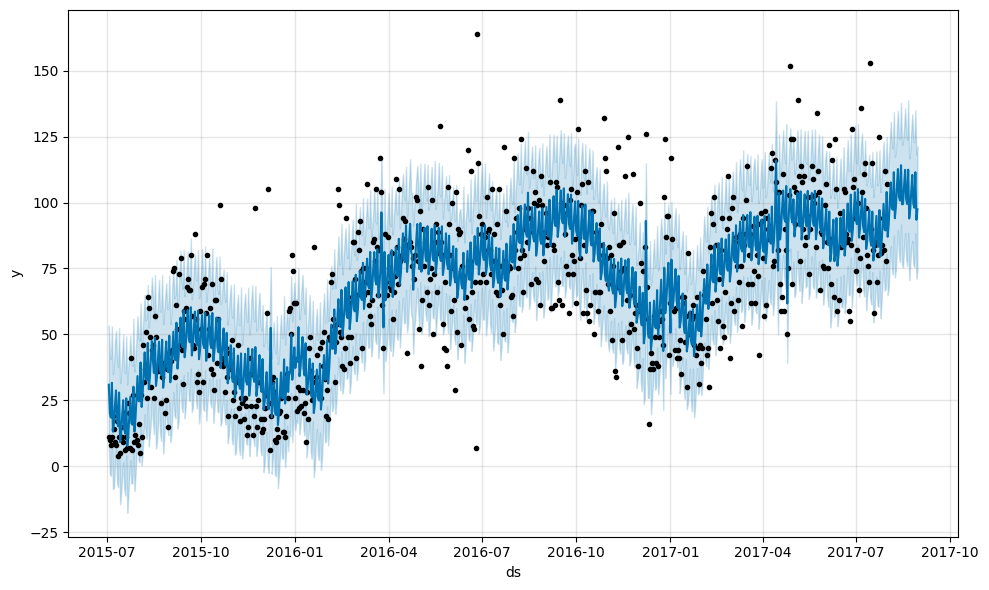

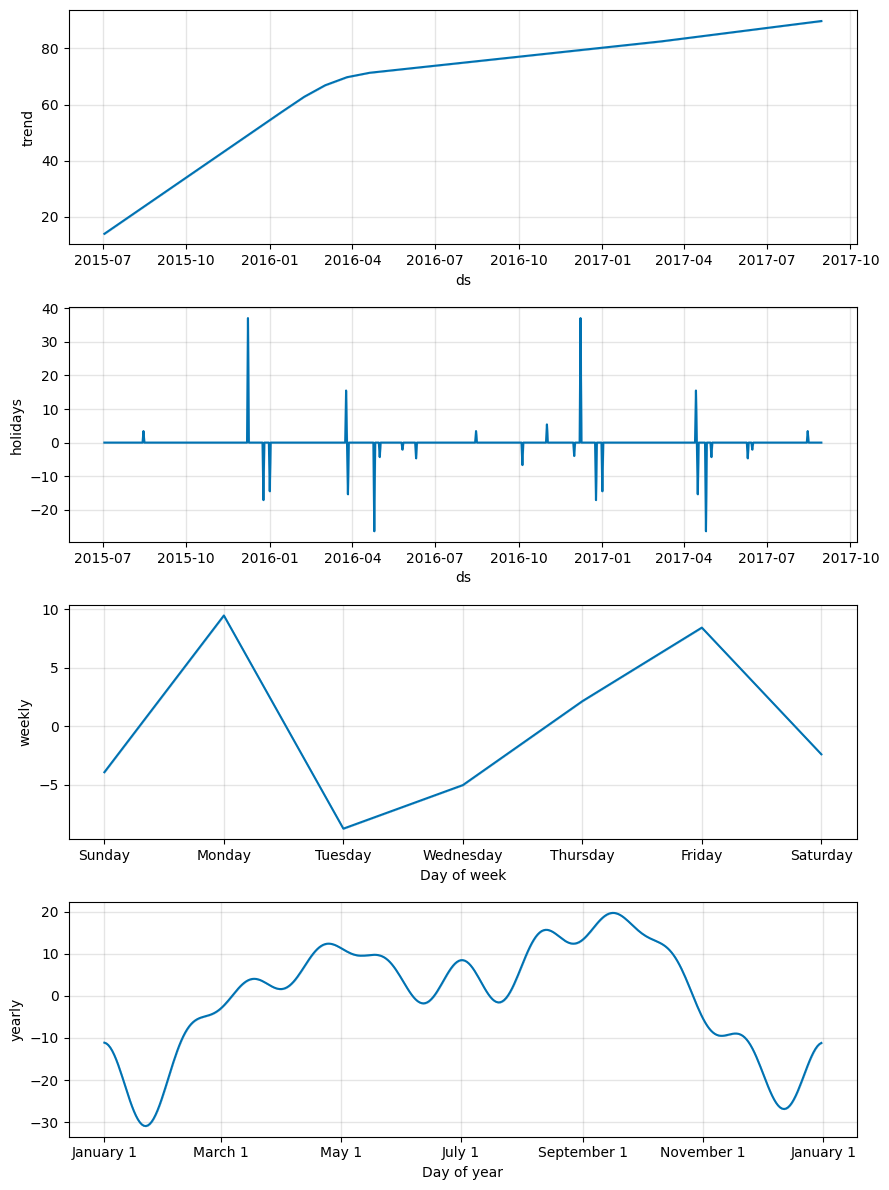

In [17]:
train_df = ts_df.loc[(ts_df['ds'] >= best_params['start_date']) & (ts_df['ds'] < '2017-08-01')]
train_df_prophet = train_df.copy()
model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    seasonality_mode=best_params['seasonality_mode'],
    weekly_seasonality=True
)
model.add_country_holidays(country_name='PT')
model.fit(train_df_prophet)
forecast = model.make_future_dataframe(periods=30)
pred = model.predict(forecast)

# Plots
prophet_plot = model.plot(pred)
prophet_plot2 = model.plot_components(pred)

Text(0, 0.5, 'Bookings')

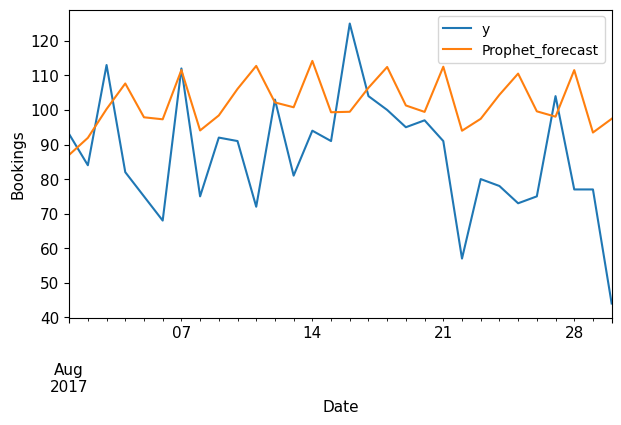

In [18]:
forecast_df = test_df.merge(pred,left_on='ds', right_on='ds', how='inner').rename(columns={'yhat':'Prophet_forecast'})

test_output_viz = forecast_df[['ds','y','Prophet_forecast']]
test_output_viz= test_output_viz.set_index('ds')

test_output_viz.plot.line(figsize=(7,4),fontsize=11)
plt.xlabel('Date', fontsize=11)
plt.ylabel('Bookings', fontsize=11)

In [19]:
print('Prophet MAE: {:.0f}'.format(mean_absolute_error(forecast_df[['Prophet_forecast']], forecast_df[['y']])))
prophet_rmse =  mean_squared_error(forecast_df[['y']], forecast_df[['Prophet_forecast']], squared=False)
prophet_mae = mean_absolute_error(forecast_df[['y']], forecast_df[['Prophet_forecast']])
print(prophet_mae)
print(prophet_rmse)

Prophet MAE: 19
18.641440124545202
22.740755751907137


# Prophet + lgbt forecasting

In [20]:
# Column name cleanup
train_df = clean_column_names(train_df)
test_df = clean_column_names(test_df)
pred = clean_column_names(pred)

# Prepare data for LightGBM
gbt_data = train_df.merge(pred, on='ds', how='left')

train_gbt, val_gbt = train_test_split(gbt_data, test_size=0.2, random_state=42)

lgbm = lgbt.OptunaLGBMRegressor(n_estimators=140, learning_rate=0.018, metric='mae', seed=42)

lgbm.fit(
    train_gbt.drop(columns=['ds', 'y'], axis=1), train_gbt.y.values,
    val_gbt.drop(columns=['ds', 'y'], axis=1), val_gbt.y.values
)

test_gbt = test_df.merge(pred, on='ds', how='left')
preds = lgbm.predict(test_gbt.drop(columns=['ds', 'y'], axis=1))

forecast_df = test_gbt[['ds', 'y', 'yhat']].copy()
forecast_df['gbt_yhat'] = preds
forecast_df['gbt_yhat'] = forecast_df['gbt_yhat'].clip(lower=0).round()

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning:

Found `n_estimators` in params. Will use it instead of argument

feature_fraction, val_score: 15.201742:  14%|#4        | 1/7 [00:01<00:07,  1.20s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning:

Found `n_estimators` in params. Will use it instead of argument

feature_fraction, val_score: 15.165965:  29%|##8       | 2/7 [00:01<00:02,  1.77it/s]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning:

Found `n_estimators` in params. Will use it instead of argument

feature_fraction, val_score: 15.165965:  43%|####2     | 3/7 [00:01<00:01,  2.73it/s]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning:

Found `n_estimators` in params. Will use it instead of argument

feature_fraction, val_score: 15.165965:  57%|#####7    | 4/7 [00:01<00:00,  3.49it/s]/usr/local/lib/py

In [21]:
print(mean_absolute_error(forecast_df['y'], forecast_df['gbt_yhat']))
print('Prophet with LGBM MAE: {:.0f}'.format(mean_absolute_error(forecast_df['y'], forecast_df['gbt_yhat'])))

16.0
Prophet with LGBM MAE: 16


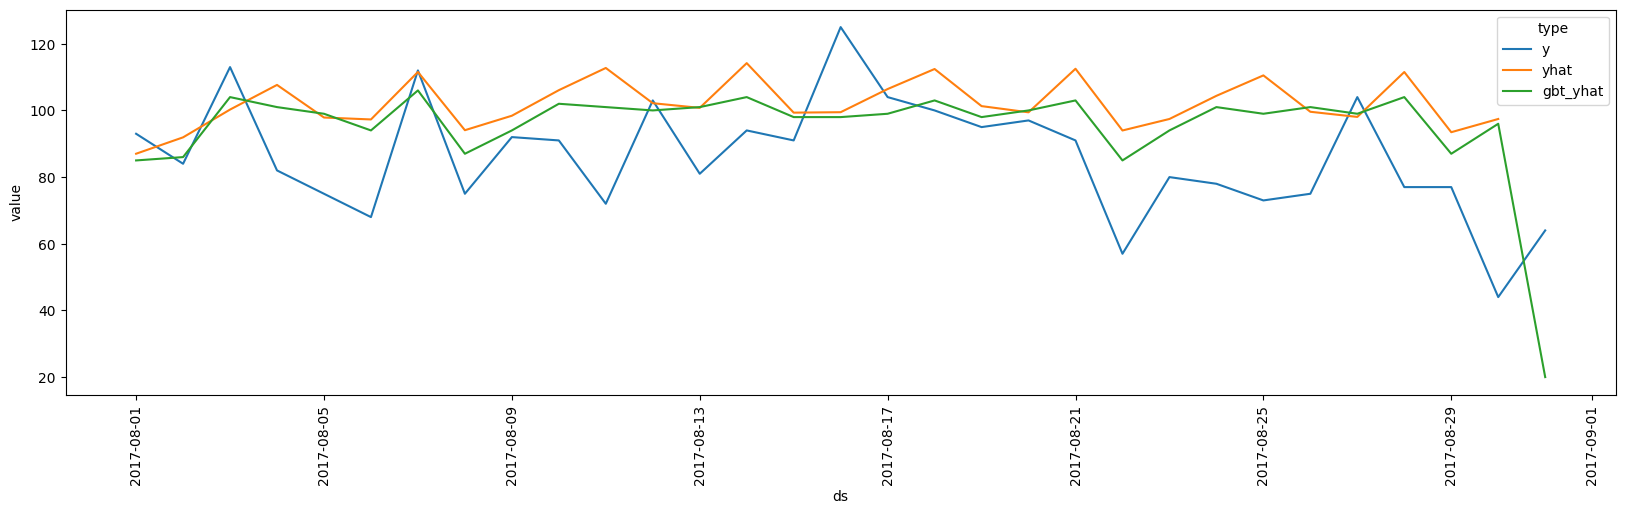

In [22]:
draw_predictions(forecast_df)